In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import PySpice.Logging.Logging as Logging
# logger = Logging.setup_logging()

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

In [2]:
def get_break_freq(gain, freq):
    mx = np.max(gain)
    for  i in range(1, len(gain)):
        if(gain[i] <= mx -3):
            return float(freq[i-1])
    return -1

In [3]:
def compute_fitness(R, C, target):
    circuit = Circuit('Low-Pass RC Filter')
    circuit.SinusoidalVoltageSource('input', 'inp', circuit.gnd, amplitude=1)
    # R1 = circuit.R(1, 'inp', 'out', R@u_kΩ)
    R1 = circuit.R(1, 'inp', 'out', R*1e3)
    # R1 = circuit.R(1, 'inp', 'out', 1e3)
    # C1 = circuit.C(1, 'out', circuit.gnd, C@u_uF)
    C1 = circuit.C(1, 'out', circuit.gnd, C*1e-6)
    # C1 = circuit.C(1, 'out', circuit.gnd, 1e-6)

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    # analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')
    analysis = simulator.ac(start_frequency=1, stop_frequency=1e6, number_of_points=100,  variation='dec')
    
    break_frequency = get_break_freq(20*np.log10(np.absolute(analysis.out).as_ndarray()), analysis.frequency)
    
    return (np.log10(1/(np.abs(break_frequency - target))), break_frequency)

In [4]:
def SGA (Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate):
    parents = np.zeros((k, n_params))
    p1 = np.zeros((n_params,))
    p2 = np.zeros((n_params,))
    Jhist = np.zeros((gens,))
    Fhist = np.zeros((gens,))
    scores = np.zeros((mu,))
    freqs = np.zeros((mu,))
    for gen in range(0, gens):
        # Pontuacao  
        for i in range(0, mu):
            scores[i], freqs[i] = compute_fitness(Xs[i, 0], Xs[i, 1], target)
            # print("Indiv: [R,C,F,S]", Xs[i, 0], Xs[i, 1], freq, scores[i])
        
        # print("Gen: ", gen)
        maxIdx = np.argmax(scores)
        # print(scores[maxIdx])
        Jhist[gen] = scores[maxIdx]
        Fhist[gen] = freqs[maxIdx]
        
        # Selecao dos Pais
        topIdx = np.argsort(scores)[::-1]
        # print("scores", scores)
        # print("np.argsort(scores)", np.argsort(scores))

        for i in range(0, k):
            for j in range(0, n_params):
                parents[i, j] = Xs[topIdx[i], j]
        
        # Crossover
        for i in range(0, mu):
            r1 = np.random.randint(0, k)
            r2 = np.random.randint(0, k)
            for j in range(0, n_params):
                Xs[i, j] = parents[r1, j]/2 + parents[r2, j]/2
        
        # Mutacao
        for i in range(0, mu):
            for j in range(0, n_params):
                if np.random.rand() <= mut_rate:
                    increment = np.random.uniform(-max_inc, max_inc)
                    Xs[i, j] += increment
                    if Xs[i, j] < limits[0] or Xs[i, j] > limits[1]:
                        Xs[i, j] -= 2*increment
        
    # Pontuacao
    maxIdx = np.argmin(scores)
    return scores[maxIdx], Xs[maxIdx, :], Jhist, Fhist

In [8]:
from tqdm.notebook import tqdm

runs = 10
mu = 10
gens = 50
k = 2
mut_rate = 0.3
n_params = 2
max_inc = 0.5
target = 1e3
n_params = 2
limits = [0.1, 10]

allX = np.zeros((runs, n_params))
allS = np.zeros((runs, 1))
allJ = np.zeros((runs, gens))
allF = np.zeros((runs, gens))
progress = 0
progress_t = 0

for j in range(0, runs):
    np.random.seed(j)

    Xs = np.random.uniform(limits[0],limits[1], (mu, n_params))
     
    minS, minX, Jhist, Fhist = SGA(Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate)
    allX[j, :] = minX
    allS[j] = minS
    allJ[j, :] = Jhist.ravel()
    allF[j, :] = Fhist.ravel()
    progress += 1
    progress_t += 1
    
    if(progress >= runs/20):
        progress = 0
        print(progress_t/runs * 100)


10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


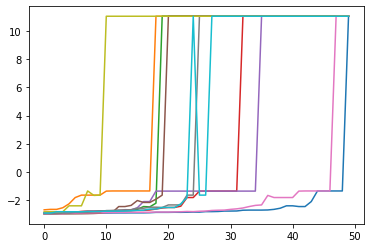

In [9]:
 import matplotlib.pyplot as plt

for i in range(0, runs):
    plt.plot(allJ[i, :])
plt.show()

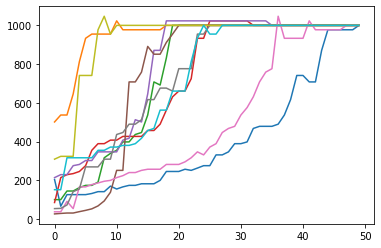

In [10]:
for i in range(0, runs):
    plt.plot(allF[i, :])
plt.show()

In [111]:
bestR = 1
bestC = 1

circuit = Circuit('Low-Pass RC Filter')
circuit.SinusoidalVoltageSource('input', 'inp', circuit.gnd, amplitude=1@u_V)
R1 = circuit.R(1, 'inp', 'out', bestR@u_kΩ)
C1 = circuit.C(1, 'out', circuit.gnd, bestC@u_uF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

# print(analysis.out)
break_frequency = get_break_freq(20*np.log10(np.absolute(analysis.out).as_ndarray()), analysis.frequency)


Should be unit less
Should be unit less


TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

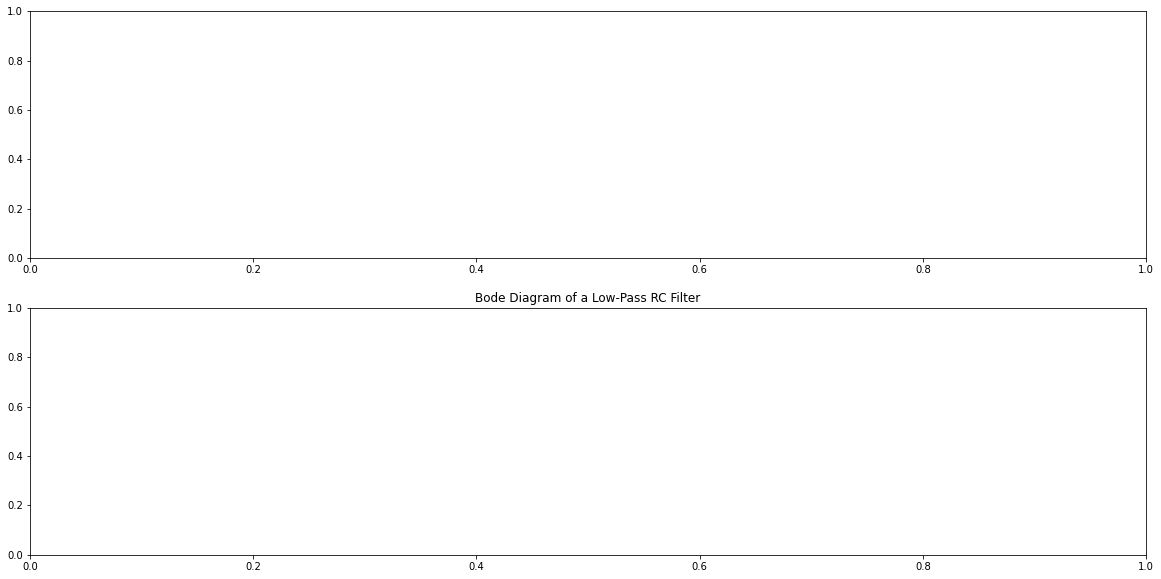

In [55]:
figure, axes = plt.subplots(2, figsize=(20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
bode_diagram(axes=axes,
             frequency=analysis.frequency,
             gain=20*np.log10(np.absolute(analysis.out)),
             phase=np.angle(analysis.out, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
)
for ax in axes:
    ax.axvline(x=break_frequency, color='red')

plt.tight_layout()
print("Break frequency = {:.1f} Hz".format(break_frequency))
print("Best Fitness = ", str(compute_fitness(bestR, bestC, target)))
plt.show()